YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  6 of 6 completed


          Retorno anualizado  Volatilidad anualizada    Sharpe   Sortino  \
Ticker                                                                     
AAPL                0.185790                0.326337  0.538676  0.733831   
AMZN                0.147535                0.362279  0.379639  0.538977   
DX-Y.NYB            0.001248                0.072140 -0.121318 -0.175359   
GLD                 0.142046                0.159763  0.826512  1.160707   
GOOGL               0.173940                0.328812  0.498583  0.677072   
MSFT                0.206363                0.305183  0.643428  0.871402   

          VaR paramétrico (95%)  ES paramétrico (95%)  VaR histórico (95%)  \
Ticker                                                                       
AAPL                  -0.033076             -0.041667            -0.032266   
AMZN                  -0.036952             -0.046489            -0.034316   
DX-Y.NYB              -0.007470             -0.009369            -0.007309   
G

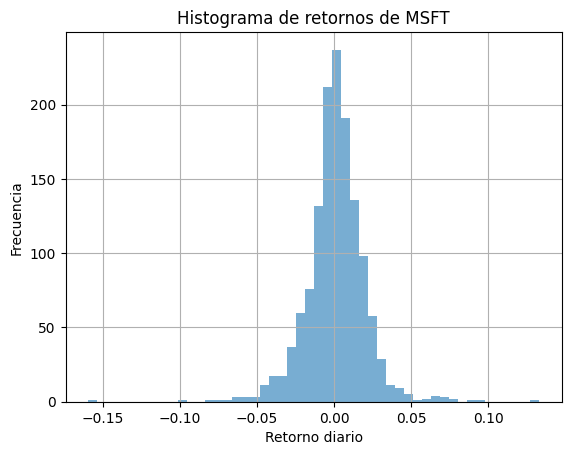

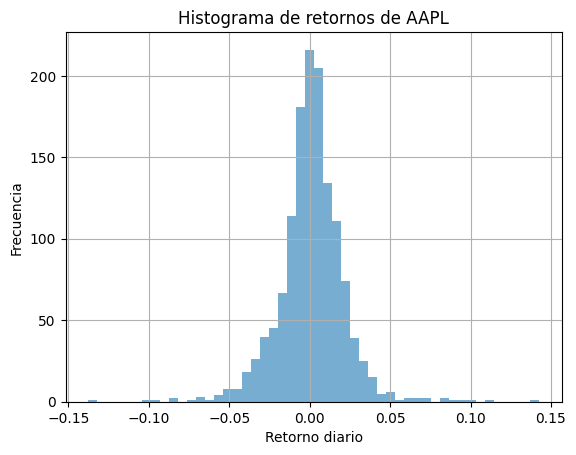

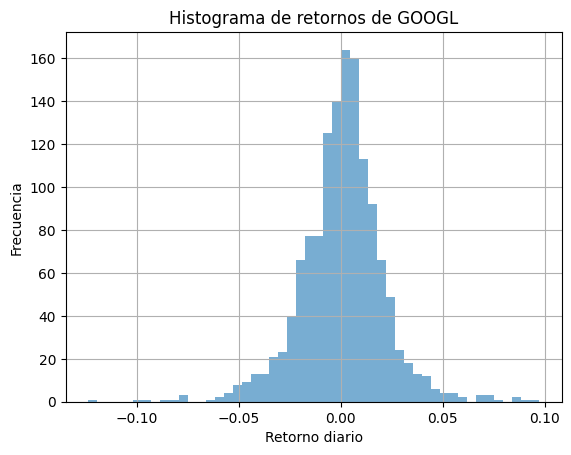

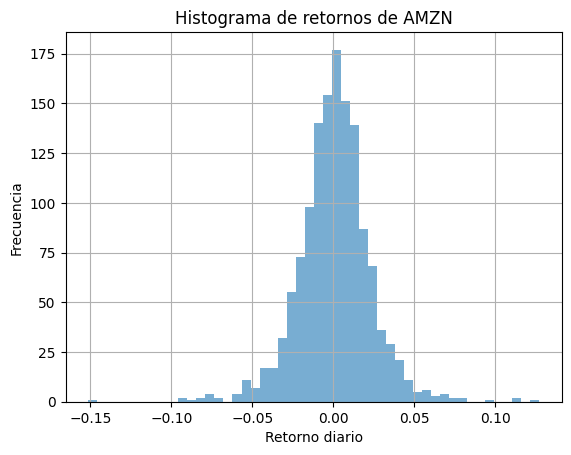

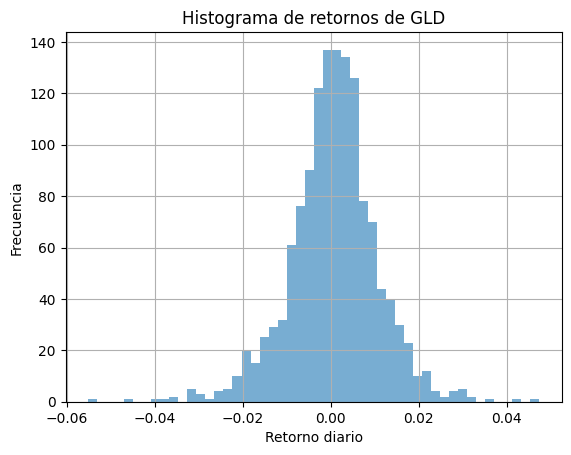

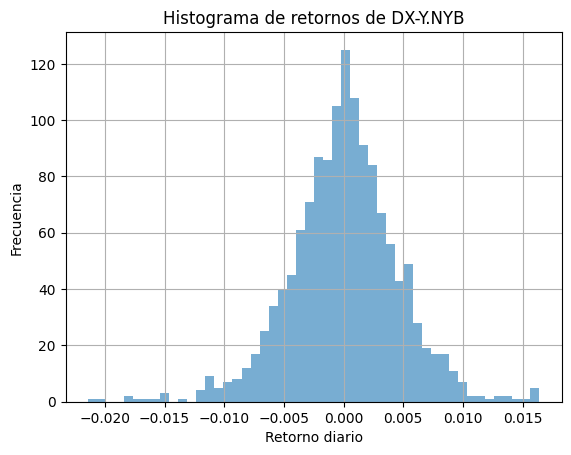

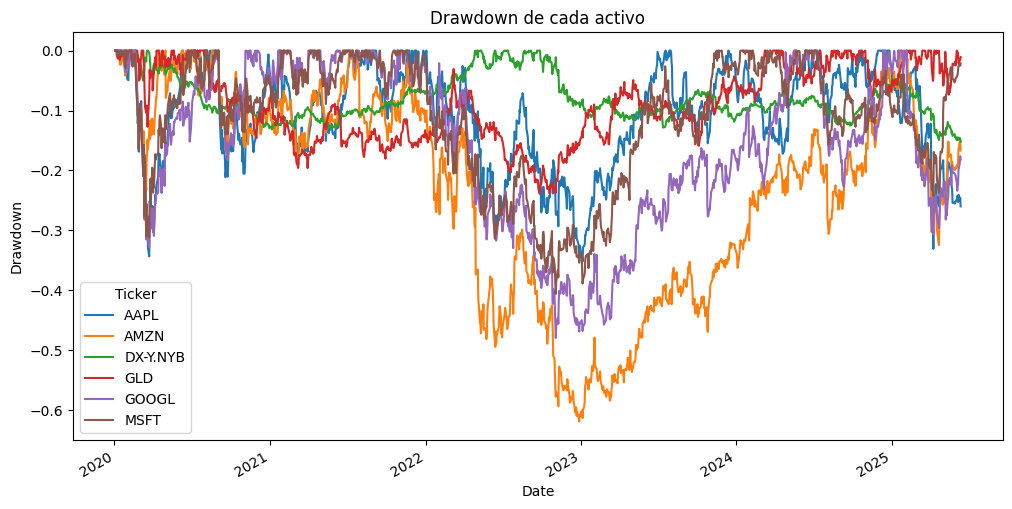

<ipython-input-1-2722724904>:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (volatilities[i], mean_returns[i]))


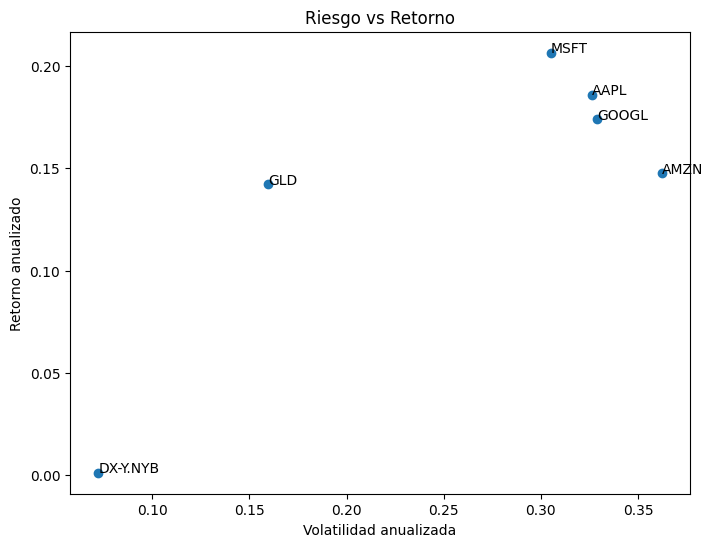

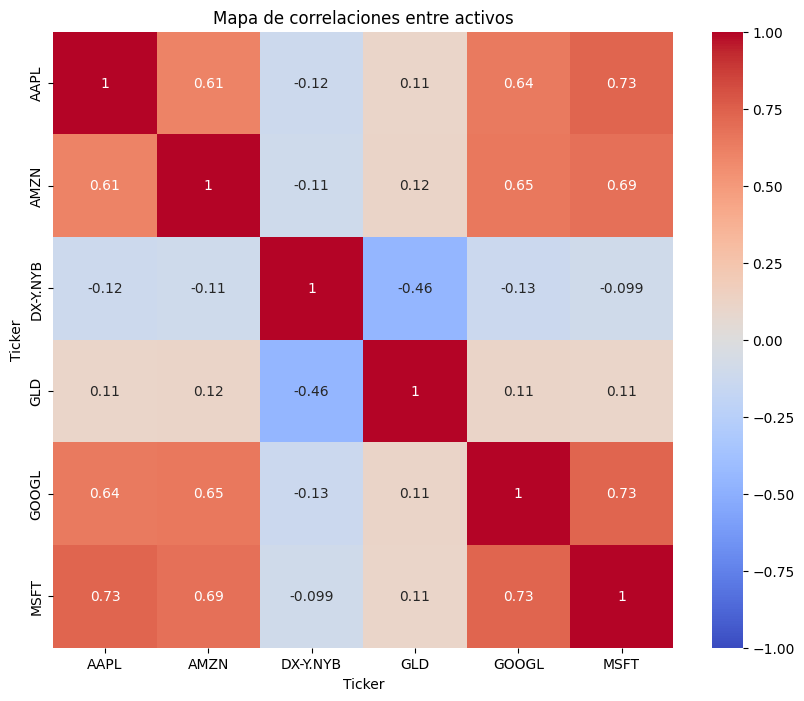

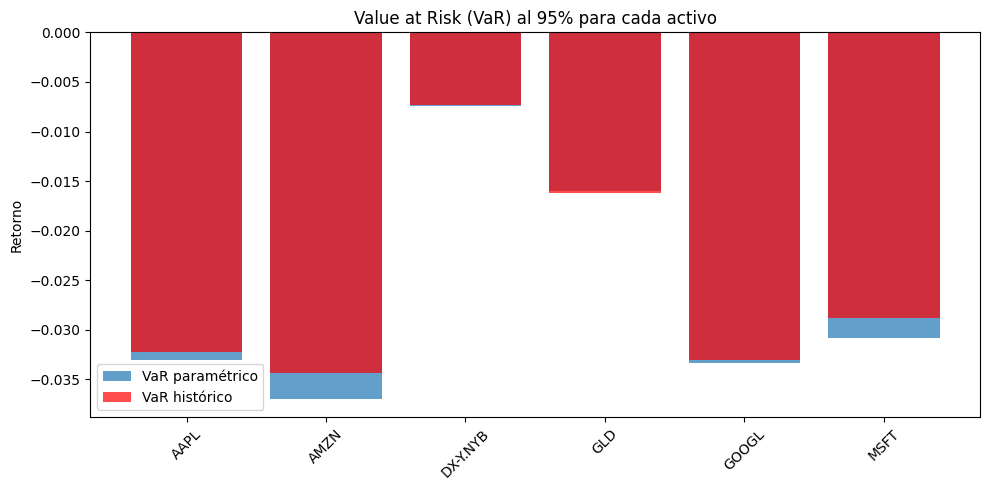

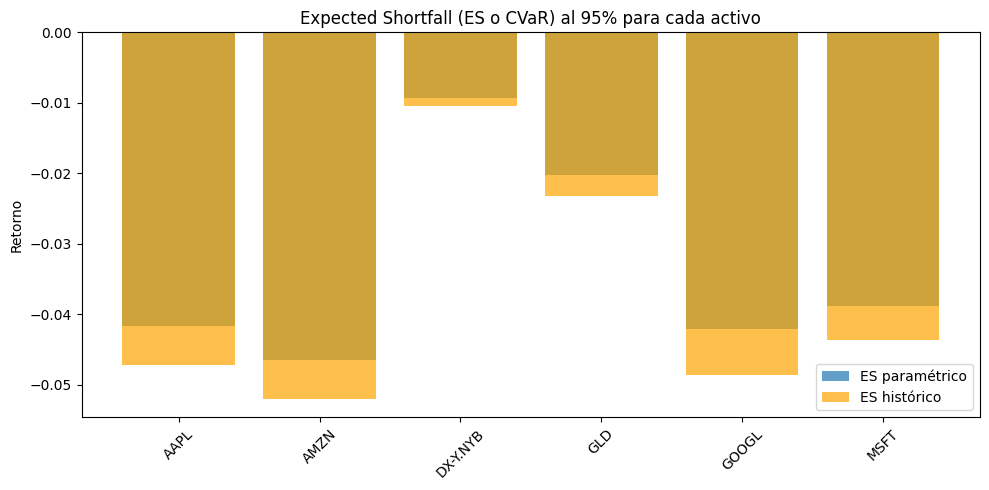

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Configuración
tickers = ['MSFT', 'AAPL', 'GOOGL', 'AMZN', 'GLD', 'DX-Y.NYB']
start_date = '2020-01-01'
risk_free_rate = 0.01  # 1% anual
alpha = 0.05  # 95% de confianza

# 2. Descarga de datos y cálculo de retornos
data = yf.download(tickers, start=start_date)['Close']
returns = np.log(data / data.shift(1)).dropna()

# 3. Estadísticas básicas
mean_returns = returns.mean() * 252
volatilities = returns.std() * np.sqrt(252)

# 4. VaR y ES (paramétrico e histórico)
VaR_param = returns.apply(lambda x: norm.ppf(alpha, x.mean(), x.std(ddof=1)))
ES_param = returns.apply(lambda x: x.mean() - x.std(ddof=1) * norm.pdf(norm.ppf(alpha)) / alpha)
VaR_hist = returns.quantile(alpha)
ES_hist = returns.apply(lambda x: x[x < x.quantile(alpha)].mean())

# 5. Sharpe y Sortino
sharpe = (mean_returns - risk_free_rate) / volatilities
downside = returns[returns < 0].std() * np.sqrt(252)
sortino = (mean_returns - risk_free_rate) / downside

# 6. Máximo Drawdown
cumulative = (1 + returns).cumprod()
running_max = cumulative.cummax()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min()

# 7. Correlación
corr_matrix = returns.corr()

# 8. Resultados en tabla
summary = pd.DataFrame({
    'Retorno anualizado': mean_returns,
    'Volatilidad anualizada': volatilities,
    'Sharpe': sharpe,
    'Sortino': sortino,
    'VaR paramétrico (95%)': VaR_param,
    'ES paramétrico (95%)': ES_param,
    'VaR histórico (95%)': VaR_hist,
    'ES histórico (95%)': ES_hist,
    'Máx Drawdown': max_drawdown
})
print(summary)

# 9. Gráficos

# Histograma de retornos
for ticker in tickers:
    returns[ticker].hist(bins=50, alpha=0.6)
    plt.title(f'Histograma de retornos de {ticker}')
    plt.xlabel('Retorno diario')
    plt.ylabel('Frecuencia')
    plt.show()

# Gráfico de drawdown
drawdown.plot(figsize=(12,6))
plt.title('Drawdown de cada activo')
plt.ylabel('Drawdown')
plt.show()

# Gráfico de riesgo-retorno
plt.figure(figsize=(8,6))
plt.scatter(volatilities, mean_returns)
for i, txt in enumerate(returns.columns):
    plt.annotate(txt, (volatilities[i], mean_returns[i]))
plt.xlabel('Volatilidad anualizada')
plt.ylabel('Retorno anualizado')
plt.title('Riesgo vs Retorno')
plt.show()

# Mapa de calor de correlaciones
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de correlaciones entre activos')
plt.show()

# Gráfico de VaR
plt.figure(figsize=(10,5))
plt.bar(VaR_param.index, VaR_param, alpha=0.7, label='VaR paramétrico')
plt.bar(VaR_hist.index, VaR_hist, alpha=0.7, label='VaR histórico', color='red')
plt.title('Value at Risk (VaR) al 95% para cada activo')
plt.ylabel('Retorno')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de ES
plt.figure(figsize=(10,5))
plt.bar(ES_param.index, ES_param, alpha=0.7, label='ES paramétrico')
plt.bar(ES_hist.index, ES_hist, alpha=0.7, label='ES histórico', color='orange')
plt.title('Expected Shortfall (ES o CVaR) al 95% para cada activo')
plt.ylabel('Retorno')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Guía de interpretación del pipeline de análisis de riesgo
1. Retorno anualizado
¿Qué es? Es el rendimiento promedio que habría obtenido el activo si se mantuviera durante un año, basado en los retornos diarios históricos.
¿Cómo se interpreta? Un valor positivo indica ganancia esperada; negativo, pérdida esperada.
2. Volatilidad anualizada
¿Qué es? Es la desviación estándar de los retornos anualizada, y mide la variabilidad o “incertidumbre” del activo.
¿Cómo se interpreta? Cuanto mayor la volatilidad, más impredecible es el activo (más riesgo).
3. Sharpe Ratio
¿Qué es? Mide el retorno extra que ofrece el activo por cada unidad de riesgo asumido, comparado con un activo libre de riesgo.
¿Cómo se interpreta? Un valor mayor a 1 es bueno; cuanto más alto, mejor relación retorno/riesgo.
4. Sortino Ratio
¿Qué es? Similar al Sharpe, pero solo penaliza la volatilidad negativa (las pérdidas).
¿Cómo se interpreta? Más alto es mejor; útil para activos con retornos asimétricos.
5. Value at Risk (VaR)
¿Qué es? Es la máxima pérdida esperada en un día (o periodo) con un nivel de confianza dado (por ejemplo, 95%).
¿Cómo se interpreta? Un VaR de -0.03 al 95% significa que hay un 5% de probabilidad de perder más del 3% en un día.
6. Expected Shortfall (ES o CVaR)
¿Qué es? Es el promedio de las peores pérdidas, es decir, el promedio de las pérdidas que superan el VaR.
¿Cómo se interpreta? Es una medida más conservadora que el VaR; muestra cuánto podrías perder en promedio en los peores escenarios.
7. Máximo Drawdown
¿Qué es? Es la mayor caída desde un máximo histórico hasta un mínimo posterior.
¿Cómo se interpreta? Indica la peor racha de pérdidas; útil para evaluar la resistencia psicológica y financiera necesaria para mantener una inversión.
8. Histograma de retornos
¿Qué es? Muestra la frecuencia de los distintos retornos diarios.
¿Cómo se interpreta? Permite ver si los retornos se distribuyen normalmente, si hay asimetría o “colas” (eventos extremos).
9. Gráfico de drawdown
¿Qué es? Muestra las caídas desde máximos históricos a lo largo del tiempo.
¿Cómo se interpreta? Permite visualizar cuándo y cuánto cayó el activo desde sus picos.
10. Gráfico riesgo-retorno
¿Qué es? Relaciona el retorno anualizado con la volatilidad anualizada de cada activo.
¿Cómo se interpreta? Activos en la parte superior izquierda (alto retorno, bajo riesgo) son los más atractivos.
11. Mapa de calor de correlaciones
¿Qué es? Muestra cómo se relacionan los retornos de los activos entre sí.
¿Cómo se interpreta? Correlaciones cercanas a 1 indican que los activos se mueven juntos; cercanas a -1, que se mueven en direcciones opuestas; cercanas a 0, que no tienen relación.
¿Cómo usar esta información?
Comparar activos: Elige los que mejor se adapten a tu perfil de riesgo.
Diversificar: Busca activos con baja correlación para reducir el riesgo total.
Gestionar el riesgo: Usa VaR, ES y drawdown para definir límites de pérdida aceptables.
Optimizar portafolios: Prefiere activos con alto Sharpe/Sortino y bajo drawdown.